<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/02_MA_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ MA(q) 모델을 활용한 테슬라 주가 예측 코드

MA(q) 모델은 시계열 데이터 분석에서 현재 값이 과거의 오차(잔차)에 의존하는 이동 평균(Moving Average) 구조를 가진 모델을 의미

MA(q) 모델의 개념

* MA(q) 모델은 시계열의 각 시점이 과거의 오차항(예측 오차)들의 가중 합으로 표현됩니다.
* 여기서 q는 과거 오차항을 고려하는 시차(차수)를 나타내며, 오차항이 많을수록 모델의 설명력이 커집니다.
* MA 모델은 예측 오차의 누적 효과를 반영해 데이터의 변동성을 설명하는 데 주로 사용됩니다.

In [1]:
# === MA(q) Forecasting — 4 Strategies (Colab-ready) ==========================
# 1) Full series  2) Fixed-origin (static)  3) Rolling window  4) Expanding window
# =============================================================================
# 0) Install deps (Colab)
# %%capture
%pip -q install yfinance statsmodels scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 5)

# 1) Data: TSLA (2022-01-01 ~ 2025-09-30)
symbol     = "TSLA"
start_date = "2022-01-01"
end_date   = "2025-09-30"

df = yf.download(symbol, start=start_date, end=end_date).reset_index()
df = df[["Date", "Close"]].dropna().copy()
y = df["Close"].to_numpy(float)
dates = pd.to_datetime(df["Date"]).to_numpy()
n = len(y)
train_size = int(n * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
dates_test = pd.to_datetime(df["Date"].iloc[train_size:])

# 2) Params & helpers
q = 10      # MA order
d = 1       # differencing order (price-level → usually 1)
W = 252     # rolling window length (≈ trading days for 1y)
h = 20      # horizons for Full series forecast

def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def r2(a, b):
    return float(r2_score(a, b))

def fit_ma_safe(series, q, d=1):
    """
    Safe ARIMA(0,d,q) fit:
    - shrink q if window is short
    - relax stationarity/invertibility to reduce failures
    """
    q_eff = max(1, min(q, max(1, len(series) - d - 1)))
    model = ARIMA(
        series, order=(0, d, q_eff), trend="n",
        enforce_stationarity=False, enforce_invertibility=False
    )
    return model.fit()


[*********************100%***********************]  1 of 1 completed


## 전체(Full series)

* 무엇을 하나요?

   전체 시계열(1…T)로 한 번만 적합 → 미래 h-step을 예측.

* 평가 관점

   학습에 테스트 구간 정보가 포함되어 데이터 누수 위험이 있어, 일반적 성능평가는 부적절.
   → 보통 최종 운영용/보고용 예측에 사용.

* 장점

   모든 정보를 활용 → 분산↓(안정적), 미래 예측 선형성/레벨 유지에 유리.

* 단점/주의

   공정한 비교/튜닝엔 부적합. 레짐 전환에 둔감.

* 팁

  h(예측 지평)만 정하면 끝. 모델/하이퍼파라미터 선택은 다른 방식으로 검증 후 최종 적합에 적용.

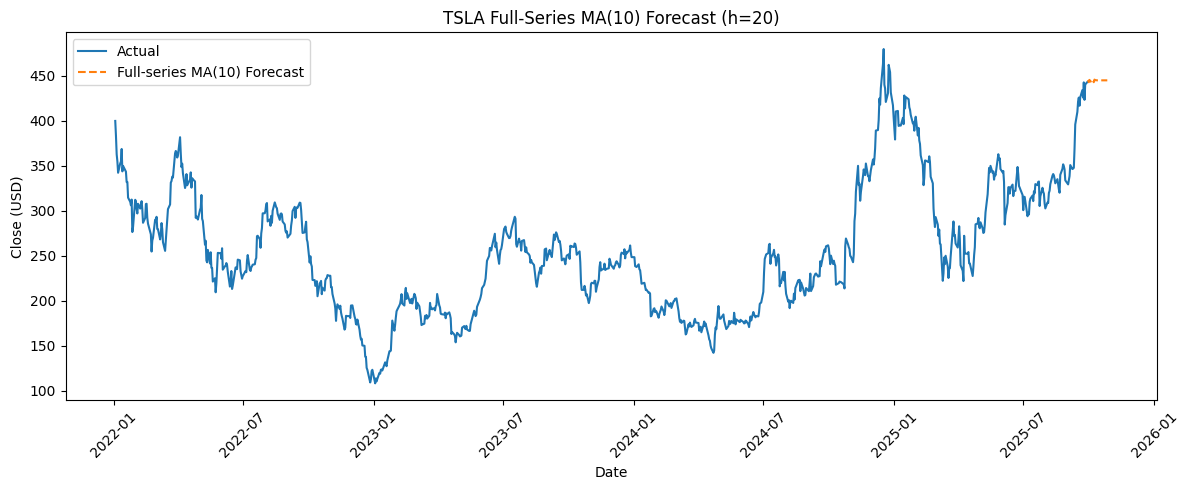

In [2]:
# 3) Full series: fit once on all & forecast future h steps
fit_full = fit_ma_safe(y, q=q, d=d)
fc_full  = fit_full.forecast(steps=h)  # ARIMA(0,1,q) returns levels
last_date = pd.to_datetime(df["Date"].iloc[-1])
fc_dates  = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=h)

plt.figure()
plt.plot(df["Date"], y, label="Actual")
plt.plot(fc_dates, fc_full, label=f"Full-series MA({q}) Forecast", linestyle="--")
plt.title(f"{symbol} Full-Series MA({q}) Forecast (h={h})")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()

## 고정 원점(=정적 파라미터, Fixed-origin / Static)

* 무엇을 하나요?

  첫 80%만 학습해 파라미터를 고정하고, 테스트 전 구간을 재귀 예측(refit 없음).

* 평가 관점

  테스트 구간의 진짜 out-of-sample 성능 제공.

* 장점

  가볍고 재현성 좋음. 운영에서 “주기적 재학습이 어려운” 상황에 현실적.

* 단점/주의

  드리프트/레짐 변화에 취약. 테스트가 길수록 성능 하락 가능.

* 팁

  테스트가 길면 주기적 재학습(예: 월별) 전략과 비교해보세요.

[Fixed-origin] RMSE=135.1980 | MAE=123.7995 | R2=-5.1864


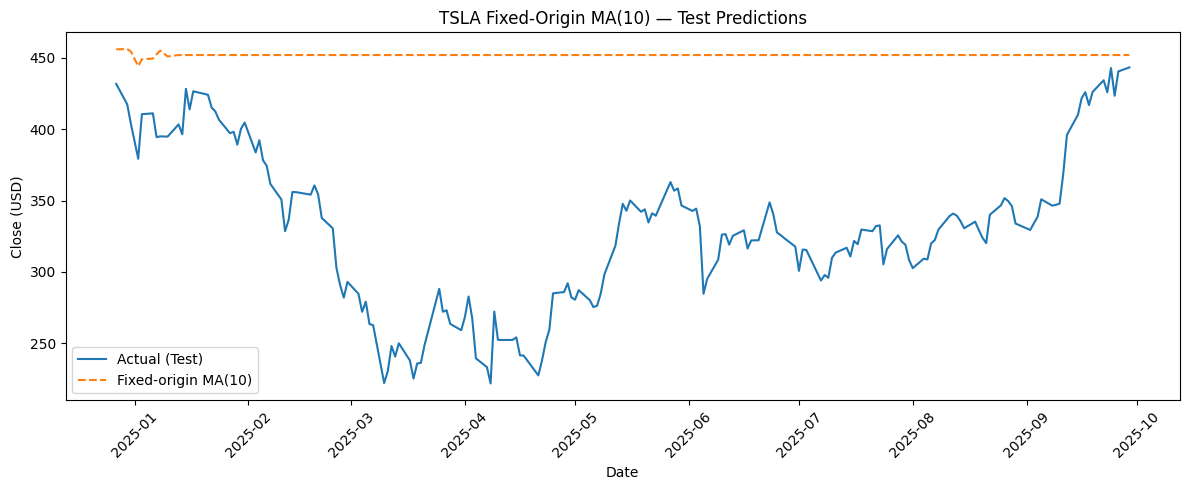

In [3]:
# 4) Fixed-origin (static): fit on 80% train, forecast full test
fit_fixed  = fit_ma_safe(y_train, q=q, d=d)
pred_fixed = fit_fixed.forecast(steps=len(y_test))

rmse_fixed = rmse(y_test, pred_fixed)
mae_fixed  = float(np.mean(np.abs(y_test - pred_fixed)))
r2_fixed   = r2(y_test, pred_fixed)
print(f"[Fixed-origin] RMSE={rmse_fixed:.4f} | MAE={mae_fixed:.4f} | R2={r2_fixed:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)")
plt.plot(dates_test, pred_fixed, label=f"Fixed-origin MA({q})", linestyle="--")
plt.title(f"{symbol} Fixed-Origin MA({q}) — Test Predictions")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()

## 롤링 윈도우(Rolling window)

* 무엇을 하나요?

  각 시점마다 최근 W개만 사용해 다시 학습 → 바로 다음 1-step 예측. 창이 한 칸씩 “밀리며” 진행.

* 평가 관점

  워크-포워드(진행형) 검증. 실제 운영 흐름에 가장 근접.

* 장점

  최근 정보에 민감 → 드리프트 대응 좋음. 계산량이 대략 일정.

* 단점/주의

  오래된 정보는 버림 → 표본 작으면 분산↑. W가 너무 작으면 과적합·불안정.

* 팁
  
  W는 q+d+몇 이상으로(예: 거래일 1년 W≈252) 시작해서 시계열 CV로 튜닝.
  
  창이 짧으면 q를 자동 축소(코드에 반영됨).

[Rolling] RMSE=13.2955 | MAE=61.8212 | R2=0.9402


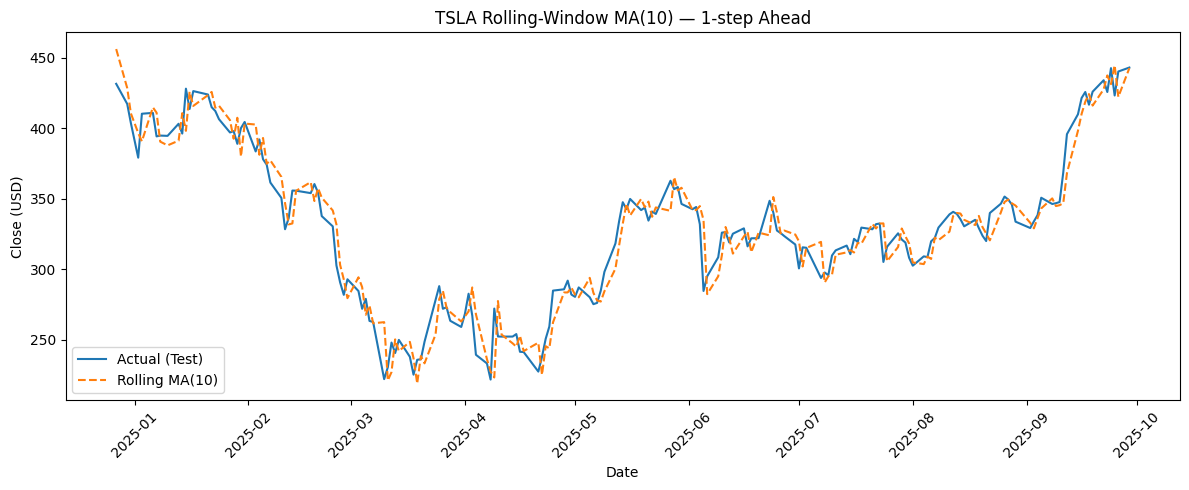

In [4]:
# 5) Rolling window: re-fit each step on the last W observations → 1-step ahead
pred_roll = np.full(len(y_test), np.nan)
for i in range(len(y_test)):
    t = train_size + i
    start_idx = max(0, t - W)
    y_win = y[start_idx:t]
    if len(y_win) < max(5, d + 2):
        continue
    try:
        fit = fit_ma_safe(y_win, q=q, d=d)
        pred_roll[i] = fit.forecast(steps=1)[0]
    except Exception:
        continue

mask_roll = ~np.isnan(pred_roll)
rmse_roll = rmse(y_test[mask_roll], pred_roll[mask_roll])
mae_roll  = float(np.mean(np.abs(y_test[mask_roll] - pred_roll[mask_roll])))
r2_roll   = r2(y_test[mask_roll], pred_roll[mask_roll])
print(f"[Rolling] RMSE={rmse_roll:.4f} | MAE={mae_roll:.4f} | R2={r2_roll:.4f}")

plt.figure()
plt.plot(dates_test[mask_roll], y_test[mask_roll], label="Actual (Test)")
plt.plot(dates_test[mask_roll], pred_roll[mask_roll], label=f"Rolling MA({q})", linestyle="--")
plt.title(f"{symbol} Rolling-Window MA({q}) — 1-step Ahead")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()

## 확장 윈도우(Expanding window)

* 무엇을 하나요?
  
  시점 t마다 처음부터 t−1까지 전부로 다시 학습 → 1-step 예측. 데이터가 계속 “쌓임”.

* 평가 관점
  
  역시 워크-포워드 검증. 롤링보다 더 많은 과거를 사용.

* 장점

  데이터 누적 → 안정적(분산↓), 작은 표본 구간에서도 견고.

* 단점/주의
  
  과거 패턴에 무게 → 환경 변화 적응이 느릴 수 있음. 계산량이 t에 따라 증가.

* 팁

  레짐 변화가 잦다면 최신 가중을 주는 하이브리드(가중 확장/반감 가중치)도 고려.\

[Expanding] RMSE=13.2983 | MAE=61.7966 | R2=0.9401


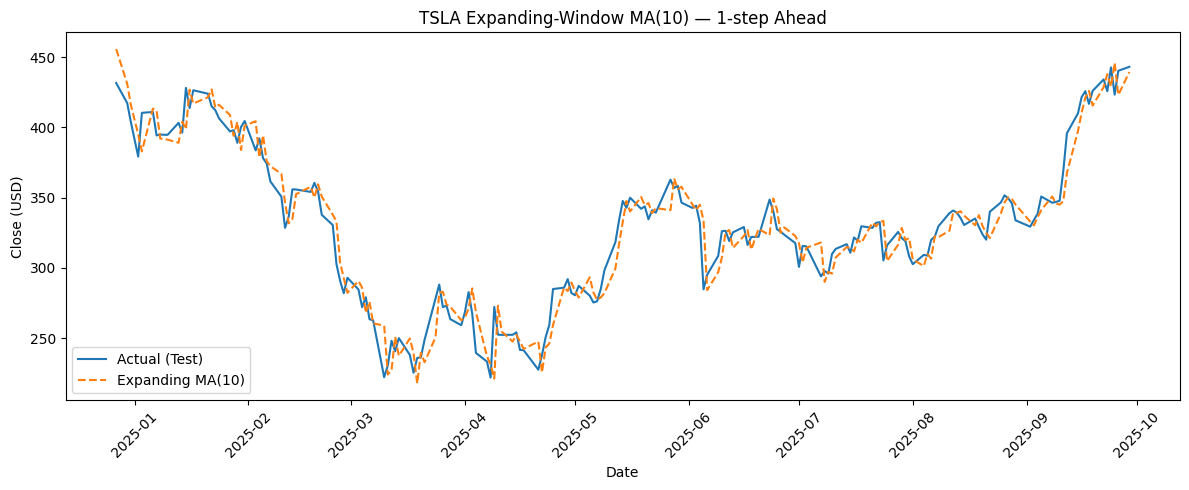

,Method,RMSE,MAE,R2
1,Rolling window,13.295466,61.821217,0.940172
2,Expanding window,13.298337,61.796576,0.940146
0,Fixed-origin (static),135.198003,123.799531,-5.186442


In [5]:
# 6) Expanding window: re-fit each step on 1..t-1 → 1-step ahead
pred_exp = np.full(len(y_test), np.nan)
for i in range(len(y_test)):
    t = train_size + i
    y_win = y[:t]
    if len(y_win) < max(5, d + 2):
        continue
    try:
        fit = fit_ma_safe(y_win, q=q, d=d)
        pred_exp[i] = fit.forecast(steps=1)[0]
    except Exception:
        continue

mask_exp = ~np.isnan(pred_exp)
rmse_exp = rmse(y_test[mask_exp], pred_exp[mask_exp])
mae_exp  = float(np.mean(np.abs(y_test[mask_exp] - pred_exp[mask_exp])))
r2_exp   = r2(y_test[mask_exp], pred_exp[mask_exp])
print(f"[Expanding] RMSE={rmse_exp:.4f} | MAE={mae_exp:.4f} | R2={r2_exp:.4f}")

plt.figure()
plt.plot(dates_test[mask_exp], y_test[mask_exp], label="Actual (Test)")
plt.plot(dates_test[mask_exp], pred_exp[mask_exp], label=f"Expanding MA({q})", linestyle="--")
plt.title(f"{symbol} Expanding-Window MA({q}) — 1-step Ahead")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
plt.show()

# 7) Summary table
summary = pd.DataFrame({
    "Method": ["Fixed-origin (static)", "Rolling window", "Expanding window"],
    "RMSE":   [rmse_fixed, rmse_roll, rmse_exp],
    "MAE":    [mae_fixed,  mae_roll,  mae_exp],
    "R2":     [r2_fixed,   r2_roll,   r2_exp],
})
summary.sort_values("RMSE")


## FAQ:

###  **자동 회귀(AR) 모델과 이동 평균(MA) 모델의 차이점은 무엇인가요?**

AR 모델과 MA 모델의 주요 차이점은 모델의 구조와 과거 관측치와의 관계에 있습니다. AR 모델에서 미래 관측값은 과거 관측값과 일부 무작위 노이즈의 선형 조합으로 모델링됩니다. 이와 대조적으로, MA 모델에서는 미래 관측값이 과거 오차 항과 일부 무작위 노이즈의 선형 조합으로 모델링됩니다. 즉, AR 모델은 시계열 자체의 과거 값을 살펴보는 반면, MA 모델은 과거 오차 항을 살펴봅니다.

### **자동 회귀(AR) 모델은 언제 사용해야 하나요?**

자동 회귀(AR) 모델은 시계열의 과거 관측치와 미래 관측치 사이에 명확한 상관관계가 있을 때 사용해야 합니다. 시계열이 자체 과거 값으로 설명할 수 있는 추세나 패턴을 보이는 경우 AR 모델은 이러한 관계를 포착하여 정확한 예측을 할 수 있습니다. 또한 고정된 시계열 데이터를 다룰 때도 유용합니다.

### **이동 평균(MA) 모델은 언제 사용해야 하나요?**

이동 평균(MA) 모델은 과거 오차 항과 시계열의 미래 관측치 사이에 명확한 상관관계가 있을 때 사용해야 합니다. 시계열에 자체 과거 오차 항으로 설명할 수 있는 잔여 패턴이나 오차가 있는 경우, 이동 평균 모델을 사용하면 이 관계를 포착하여 정확한 예측을 할 수 있습니다. 또한 고정된 시계열 데이터를 다룰 때도 유용합니다.

### **자동 회귀(AR) 모델과 이동 평균(MA) 모델을 함께 사용할 수 있나요?**

예. 자동 회귀(AR) 모델과 이동 평균(MA) 모델을 결합하여 자동 회귀 이동 평균(ARMA) 모델로 사용할 수 있습니다. ARMA 모델은 예측을 위해 시계열의 과거 값과 과거 오차 항을 모두 통합합니다. 이를 통해 시계열의 장기적인 패턴과 존재할 수 있는 잔여 오차를 모두 포착할 수 있습니다.

### **자동 회귀(AR) 및 이동 평균(MA) 모델의 적용 분야에는 어떤 것이 있나요?**

자동 회귀(AR) 및 이동 평균(MA) 모델은 금융, 경제, 신호 처리 등 다양한 분야에서 널리 사용됩니다. 시계열 분석, 예측 및 예측, 노이즈 감소, 패턴 인식, 이상 징후 감지 등에 사용할 수 있습니다. 이러한 모델은 데이터의 미래 추세와 행동을 이해하고 예측하는 데 도움이 될 수 있으며, 이는 의사 결정과 계획에 유용합니다.

### **자동 회귀(AR) 모델이란 무엇인가요?**

자동 회귀(AR) 모델은 데이터 집합의 과거 값을 기반으로 미래 값을 예측하는 시계열 모델의 한 유형입니다. 이 모델은 시계열의 현재 값이 과거 값에 선형적으로 의존한다고 가정합니다.

# SMA

## **ARIMA의 MA(q)**와 **SMA(단순이동평균)**은 이름이 비슷해도 **완전히 다른 개념**

# 개념 차이

* **SMA (Simple Moving Average)**
  값 자체 (y_t)를 최근 (p)개 평균으로 **단순 평활**:

  * **학습/추정 없음**(파라미터는 창 길이 (p)뿐)
  * 주로 **노이즈 제거·시각화**용, 1-step 롤링 예측엔 OK, **멀티-스텝**에선 예측값을 계속 평균하다가 **평평해지기 쉬움**(트렌드 추세를 “따라가되 뒤늦게” 반응)

* **ARIMA(p,d,q) (여기서는 MA(q)=ARIMA(0,d,q))**
  **오차(충격)**의 이동평균을 모형화:


# 무엇을 “평균”하나?

* **SMA**: 과거 **관측값 (y)**를 평균 → **평활 필터**
* **MA(q)**: 예측오차 (\varepsilon)의 선형결합 → **확률모형**

# 실전 차이

* **학습**:

  * SMA: 없음 → 창 길이 (p)만 정하면 끝
  * ARIMA: ((p,d,q)) 설정 + **모수 추정**(AIC/BIC, CV로 튜닝)
* **비정상성 처리**:

  * SMA: 없음(그냥 평균) → **드리프트/레짐 변화를 뒤늦게** 반영
  * ARIMA: (d) 차분으로 처리 → **확률적 트렌드**에 더 적합
* **멀티-스텝 예측**:

  * SMA: 예측값을 다시 평균하면 **점점 평탄**해짐
  * ARIMA: 모형 구조로 **동적 전개**(+ 불확실성 추정)
* **평가 방식에 민감**:

  * **SMA 1-step 롤링**은 매 시점 **실제값**을 창에 넣어 예측 → 보통 **낙관적**
  * **ARIMA 고정원점(정적 파라미터) 동적 예측**은 **실제값 미사용** → 더 **엄격**한 out-of-sample

# 언제 무엇을?

* **빠른 baseline·시각화·신호**: **SMA**
* **통계적 예측·신뢰구간·멀티-스텝·비정상성**: **ARIMA(특히 d=1)**
* **레짐 변화에 민감**: 롤링/리핏 전략(ARIMA도 **롤링/확장 윈도우**로 운영 가능)

# 미니 코드 비교

* **SMA 1-step 롤링**(매 시점 직전 (p)개 실제값 사용):

```python
yhat_t1 = np.mean(y[t-p+1:t+1])  # 실제값만으로 1-step
```

* **SMA “동적” 멀티-스텝**(실제값 미사용, 예측만 이어붙임 → 평탄화 경향):

```python
window = deque(y_train[-p:], maxlen=p)
for k in range(H):
    yhat = np.mean(window)
    window.append(yhat)  # 예측값으로 창 갱신
```

* **ARIMA(0,1,q) 고정원점(정적 파라미터)·동적 예측**:

```python
fit = ARIMA(y_train, order=(0,1,q)).fit()
pred = fit.forecast(steps=len(y_test))  # 실제값 미사용 멀티-스텝
```

---

## 한 줄 요약

* **SMA**는 값의 **평균으로 평활**하는 **규칙 기반** 방법,
* **ARIMA의 MA(q)**는 **오차 구조를 학습**해서 **예측**하는 **확률모형**.
  이름만 비슷하고, 목적·수학·예측 성질이 다릅니다.


A) ARIMA(0,1,q) 고정 원점(정적 파라미터): 학습 80%에서 적합 → 테스트 전 구간 동적 예측

B) SMA(단순이동평균) “순수 동적”: 테스트에서 실제값을 쓰지 않고, 예측만 이어붙임

C) SMA 1-step 롤링: 매 시점 직전 p개 실제값으로 예측(워크-포워드)

[*********************100%***********************]  1 of 1 completed


[A: ARIMA static] RMSE=20.1360 | MAE=15.4153 | R2=-0.3355


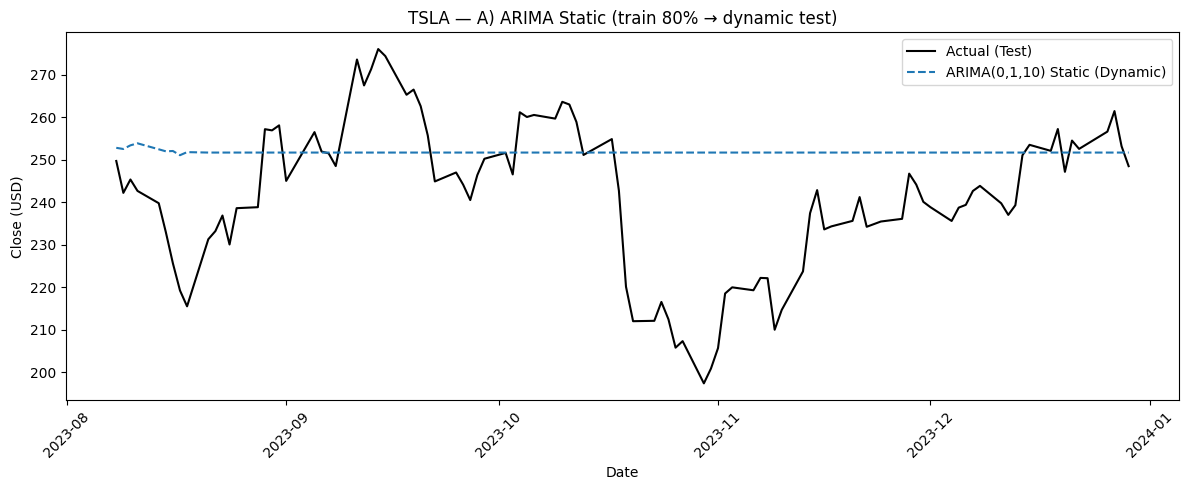

[B: SMA dynamic] RMSE=23.8308 | MAE=18.6557 | R2=-0.8705


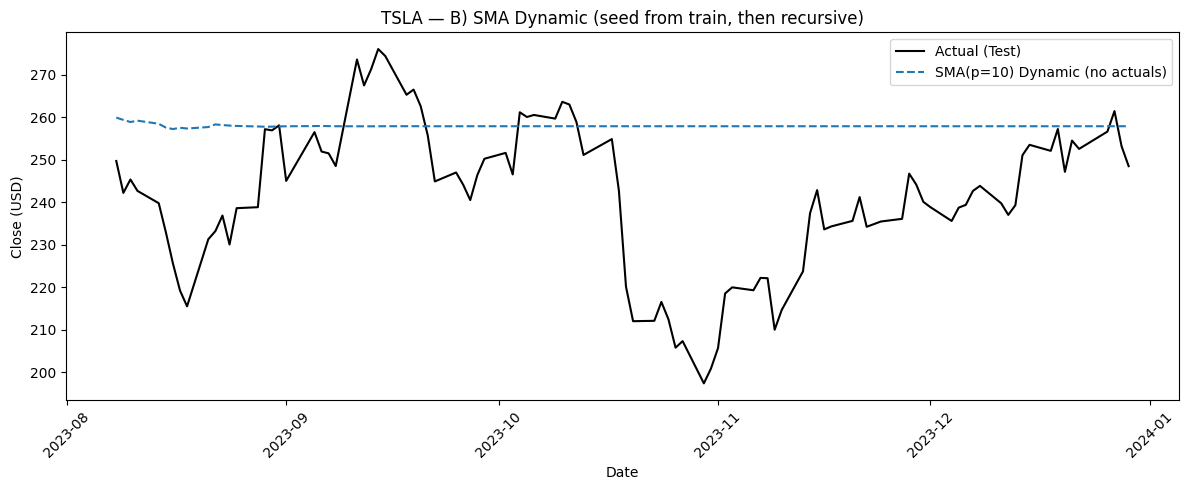

[C: SMA 1-step rolling] RMSE=14.3438 | MAE=11.3103 | R2=0.3223


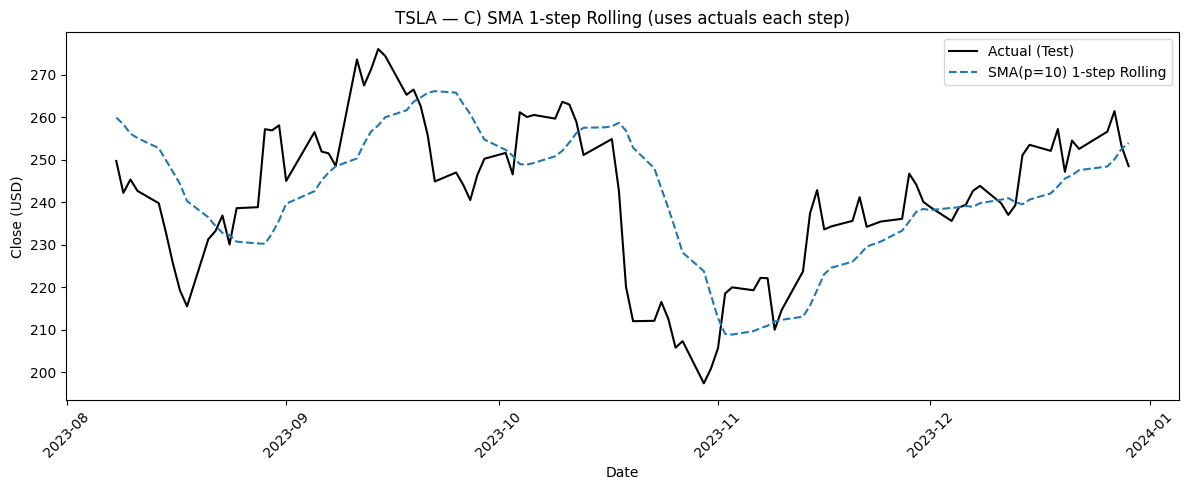


=== Summary (lower RMSE/MAE is better; R2 closer to 1 is better) ===


,Method,RMSE,MAE,R2
2,C) SMA(p=10) 1-step rolling,14.343810,11.310317,0.322334
0,"A) ARIMA(0,1,10) static (dynamic)",20.135993,15.415251,-0.335466
1,B) SMA(p=10) dynamic (no actuals),23.830758,18.655697,-0.870521


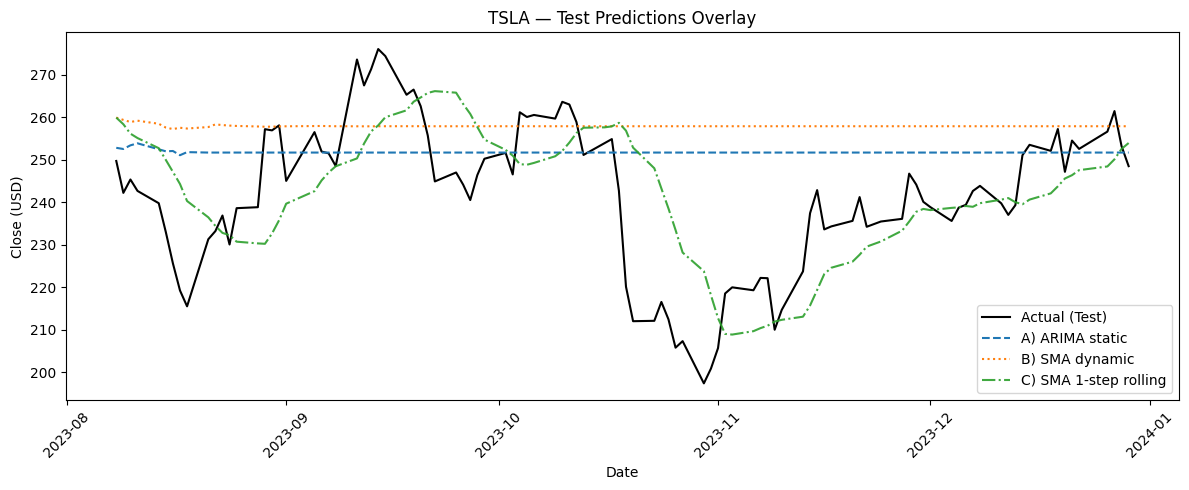

In [9]:
# ==================== Colab 준비 ====================
# %%capture
%pip -q install yfinance statsmodels scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from collections import deque
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 5)

# ==================== 데이터 로드 ====================
symbol     = "TSLA"
start_date = "2022-01-01"
end_date   = "2024-01-01"

df = yf.download(symbol, start=start_date, end=end_date).reset_index()
df = df[["Date", "Close"]].dropna().copy()

# ✅ 1D float 벡터로 강제
y = df["Close"].astype(float).to_numpy().ravel()
dates = pd.to_datetime(df["Date"]).to_numpy()

n = len(y)
train_size = int(n * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
dates_train = dates[:train_size]
dates_test  = dates[train_size:]

# ==================== 헬퍼 ====================
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(np.mean(np.abs(a - b)))
def r2(a, b):   return float(r2_score(a, b))

def fit_ma_safe(series, q, d=1):
    """
    ARIMA(0,d,q) 안전 적합:
      - 창이 짧으면 q 자동 축소
      - stationarity/invertibility 제약 완화
    """
    q_eff = max(1, min(q, max(1, len(series) - d - 1)))
    model = ARIMA(series, order=(0, d, q_eff), trend="n",
                  enforce_stationarity=False, enforce_invertibility=False)
    return model.fit()

# 하이퍼파라미터
q = 10      # ARIMA의 MA 차수
p = 10      # SMA 창 길이
d = 1       # 차분 차수 (레벨 → 1차 권장)

# ====================================================
# A) ARIMA(0,1,q) - 고정 원점(정적 파라미터), 동적 예측
# ====================================================
fit_arima = fit_ma_safe(y_train, q=q, d=d)
pred_arima_static = fit_arima.forecast(steps=len(y_test))  # 테스트 전 구간 동적 예측

rmse_a = rmse(y_test, pred_arima_static)
mae_a  = mae(y_test, pred_arima_static)
r2_a   = r2(y_test, pred_arima_static)
print(f"[A: ARIMA static] RMSE={rmse_a:.4f} | MAE={mae_a:.4f} | R2={r2_a:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_arima_static, label=f"ARIMA(0,1,{q}) Static (Dynamic)", linestyle="--")
plt.title(f"{symbol} — A) ARIMA Static (train 80% → dynamic test)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# ====================================================
# B) SMA “순수 동적” — 테스트에서 실제값 미사용(예측만 이어붙임)
# ====================================================
if len(y_train) < p:
    raise ValueError("학습 구간이 p보다 짧습니다. p를 줄이세요.")

# ✅ deque + 러닝합으로 안정/고속 구현 (항상 float만 보관)
window = deque(map(float, y_train[-p:]), maxlen=p)
w_sum  = float(sum(window))
pred_sma_dynamic = []

for _ in range(len(y_test)):
    yhat = w_sum / p                     # 창 평균
    pred_sma_dynamic.append(float(yhat))
    oldest = window[0]                   # pop될 가장 오래된 값
    window.append(float(yhat))           # 예측값으로 창 갱신(실제값 미사용)
    w_sum += float(yhat) - float(oldest) # 러닝합 업데이트

pred_sma_dynamic = np.array(pred_sma_dynamic, dtype=float)

rmse_b = rmse(y_test, pred_sma_dynamic)
mae_b  = mae(y_test, pred_sma_dynamic)
r2_b   = r2(y_test, pred_sma_dynamic)
print(f"[B: SMA dynamic] RMSE={rmse_b:.4f} | MAE={mae_b:.4f} | R2={r2_b:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_sma_dynamic, label=f"SMA(p={p}) Dynamic (no actuals)", linestyle="--")
plt.title(f"{symbol} — B) SMA Dynamic (seed from train, then recursive)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# ====================================================
# C) SMA 1-step 롤링 — 매 시점 직전 p개 실제값으로 예측
# ====================================================
# 초기 창: 학습 구간 마지막 p개 실제값
window = deque(map(float, y_train[-p:]), maxlen=p)
w_sum  = float(sum(window))
pred_sma_rolling = np.full(len(y_test), np.nan, dtype=float)

for i in range(len(y_test)):
    # 1-step 예측은 직전 p개 "실제값" 평균
    yhat = w_sum / p
    pred_sma_rolling[i] = float(yhat)

    # 다음 시점 준비: 실제값을 창에 넣음 (워크-포워드)
    actual_next = float(y_test[i])
    oldest = window[0]
    window.append(actual_next)
    w_sum += actual_next - float(oldest)

mask_roll = ~np.isnan(pred_sma_rolling)
rmse_c = rmse(y_test[mask_roll], pred_sma_rolling[mask_roll])
mae_c  = mae(y_test[mask_roll], pred_sma_rolling[mask_roll])
r2_c   = r2(y_test[mask_roll], pred_sma_rolling[mask_roll])
print(f"[C: SMA 1-step rolling] RMSE={rmse_c:.4f} | MAE={mae_c:.4f} | R2={r2_c:.4f}")

plt.figure()
plt.plot(dates_test[mask_roll], y_test[mask_roll], label="Actual (Test)", color="black")
plt.plot(dates_test[mask_roll], pred_sma_rolling[mask_roll], label=f"SMA(p={p}) 1-step Rolling", linestyle="--")
plt.title(f"{symbol} — C) SMA 1-step Rolling (uses actuals each step)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# ====================================================
# 세 방법 비교 (표 & 오버레이)
# ====================================================
summary = pd.DataFrame({
    "Method": [
        f"A) ARIMA(0,1,{q}) static (dynamic)",
        f"B) SMA(p={p}) dynamic (no actuals)",
        f"C) SMA(p={p}) 1-step rolling"
    ],
    "RMSE": [rmse_a, rmse_b, rmse_c],
    "MAE":  [mae_a,  mae_b,  mae_c],
    "R2":   [r2_a,   r2_b,   r2_c]
})
print("\n=== Summary (lower RMSE/MAE is better; R2 closer to 1 is better) ===")
display(summary.sort_values("RMSE"))

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black", linewidth=1.5)
plt.plot(dates_test, pred_arima_static, label="A) ARIMA static", linestyle="--")
plt.plot(dates_test, pred_sma_dynamic, label="B) SMA dynamic", linestyle=":")
plt.plot(dates_test[mask_roll], pred_sma_rolling[mask_roll], label="C) SMA 1-step rolling", linestyle="-.", alpha=0.9)
plt.title(f"{symbol} — Test Predictions Overlay")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()


[*********************100%***********************]  1 of 1 completed


📌 Training MSE: 356.5894, R²: 0.8969
📌 Test MSE: 197.3093, R²: 0.3787


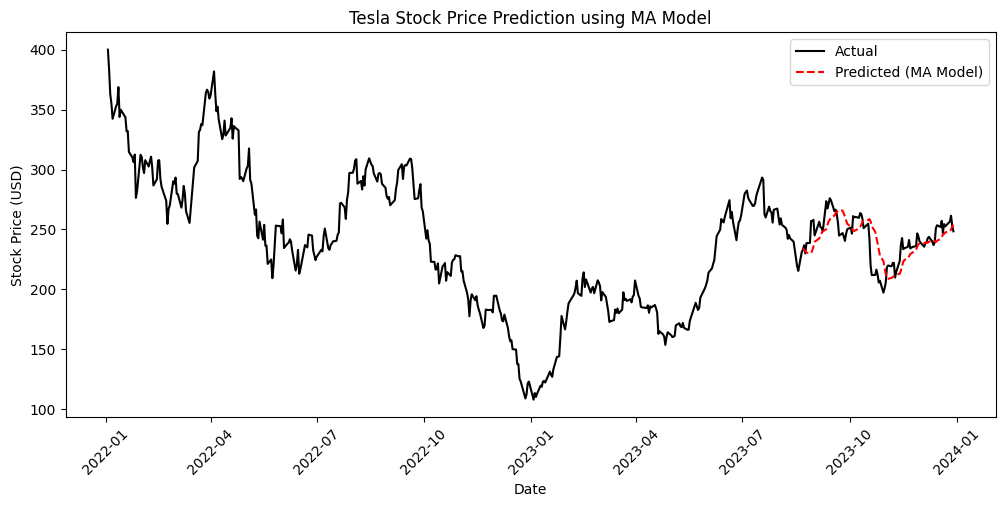

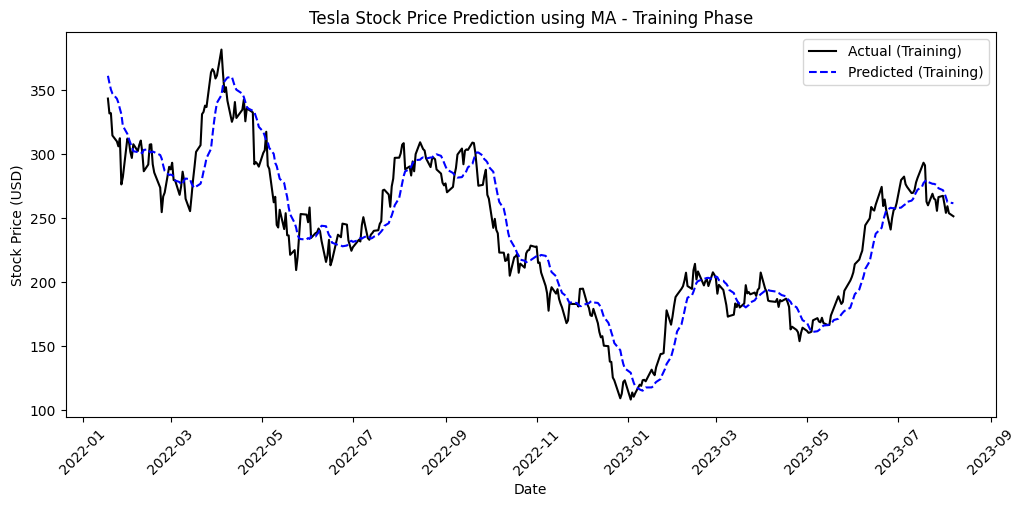

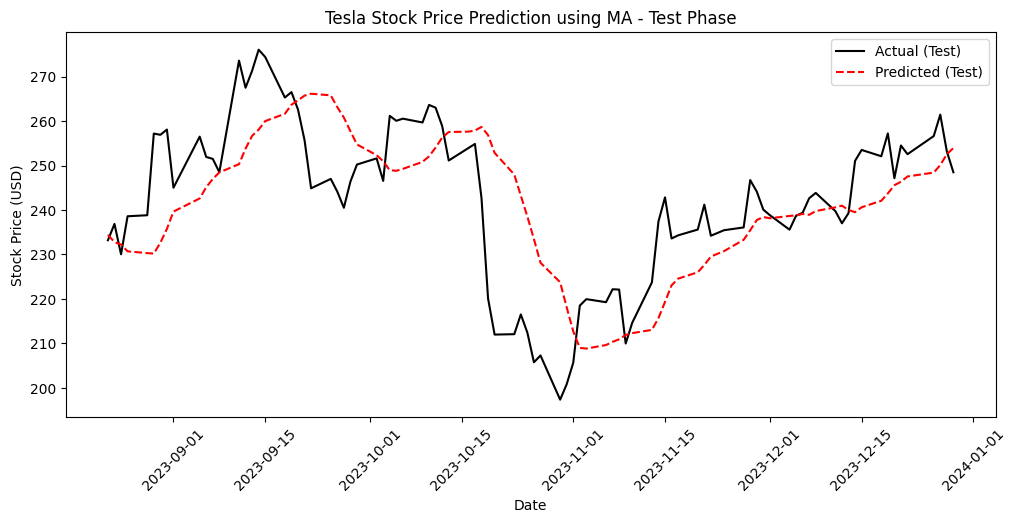

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 📌 1️⃣ 테슬라(TSLA) 주가 데이터 다운로드 (최근 2년치)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# 데이터프레임 변환
df = df.reset_index()

# 📌 2️⃣ 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()  # ✅ `.copy()` 추가

# 📌 3️⃣ MA(p) 모델 학습
p = 10  # 이동 평균 윈도우 크기
train.loc[:, "SMA"] = train["Close"].rolling(window=p).mean()  # ✅ `.loc[]` 사용
test.loc[:, "SMA"] = test["Close"].rolling(window=p).mean()  # ✅ `.loc[]` 사용

# 📌 4️⃣ 예측 수행 (1-step shift)
train["Predicted"] = train["SMA"].shift(1)
test["Predicted"] = test["SMA"].shift(1)

# 📌 5️⃣ 성능 평가 (결측값 제거 후 평가)
train_actual = train["Close"][p:]  # 실제값
train_pred = train["Predicted"][p:]  # 예측값
test_actual = test["Close"][p:]
test_pred = test["Predicted"][p:]

train_mse = mean_squared_error(train_actual, train_pred)
test_mse = mean_squared_error(test_actual, test_pred)
train_r2 = r2_score(train_actual, train_pred)
test_r2 = r2_score(test_actual, test_pred)

print(f"📌 Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"📌 Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

# 📌 6️⃣ 결과 시각화 (전체 데이터 예측)
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"], label="Actual", color="black")
plt.plot(test["Date"][p:], test_pred, label="Predicted (MA Model)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using MA Model")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 📌 7️⃣ 결과 시각화 (훈련 데이터 예측 vs 실제값)
plt.figure(figsize=(12, 5))
plt.plot(train["Date"][p:], train_actual, label="Actual (Training)", color="black")
plt.plot(train["Date"][p:], train_pred, label="Predicted (Training)", color="blue", linestyle="--")
plt.title("Tesla Stock Price Prediction using MA - Training Phase")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 📌 8️⃣ 결과 시각화 (테스트 데이터 예측 vs 실제값)
plt.figure(figsize=(12, 5))
plt.plot(test["Date"][p:], test_actual, label="Actual (Test)", color="black")
plt.plot(test["Date"][p:], test_pred, label="Predicted (Test)", linestyle="--", color="red")
plt.title("Tesla Stock Price Prediction using MA - Test Phase")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()
